# Praca domowa nr 6
Author: Piotr Halama

In [1]:
import random
from copy import copy

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from lightgbm import LGBMClassifier

from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, Normalizer
from sklearn.linear_model import LassoCV, Lasso
from sklearn_pandas import DataFrameMapper

from pygam import LinearGAM

from scipy.stats import f

##### Data

In [2]:
data = pd.read_stata('../../../HCMST 2017 fresh sample for public sharing draft v1.1.dta')

variables = ['w6_q21d_month', 'w6_q21d_year', 'w6_q25', 'w6_q26']

Chosen variables:
- w6_q21d_month - Month subject married partner
- w6_q21d_year - Year subject married partner
- w6_q25 - Did subject and partner attend same high school?
- w6_q26 - Did subject and partner attend same college?

Target variable: S1 - Are you married?

##### Preprocessing

In [3]:
X = data[variables]
y = data['S1']

X = X[pd.notnull(y)]
y = y[pd.notnull(y)]

months = [
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
    'September', 'October', 'November', 'December'
]

X['w6_q21d_month'] = X['w6_q21d_month'].astype('category').cat.set_categories(
    months, ordered=True)

X['w6_q25'] = X['w6_q25'].astype('category').cat.as_unordered()
X['w6_q26'] = X['w6_q26'].astype('category').cat.set_categories(
    ['Refused', 'Same College', 'Different College'],
    rename=True,
    ordered=False)
y = y.astype('category')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1)

##### Model

The classifier used here is based on gradient boosting from `LightGBM` package.

In [4]:
clf = LGBMClassifier(reg_alpha=0.5, random_state=0)
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=0, reg_alpha=0.5, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [5]:
y_pred = clf.predict(X_test)

f1_score(y_test, y_pred, pos_label='Yes, I am Married')

0.9623915139826423

##### Auxiliary model

I have chosen `Lasso` as auxiliary model to check correctness of homework results.

In [6]:
X_train_aux = X_train.copy()
X_test_aux = X_test.copy()

for col in ['w6_q21d_month', 'w6_q25', 'w6_q26']:
    X_train_aux[col] = X_train_aux[col].cat.add_categories(['missing']).fillna('missing')
    X_test_aux[col] = X_test_aux[col].cat.add_categories(['missing']).fillna('missing')

X_train_aux['w6_q21d_year'] = X_train_aux['w6_q21d_year'].fillna(1970)
X_test_aux['w6_q21d_year'] = X_test_aux['w6_q21d_year'].fillna(1970)

y_train_aux = (y_train == 'Yes, I am Married')
y_test_aux = (y_test == 'Yes, I am Married')

In [7]:
mapper = DataFrameMapper([
    (['w6_q21d_year'], Normalizer()), 
    ('w6_q21d_month', LabelBinarizer()),
    ('w6_q25', LabelBinarizer()),  
    ('w6_q26', LabelBinarizer()), 
])

clf_aux = Pipeline([('mapper', mapper), ('clf', LassoCV(cv=3))])

clf_aux.fit(X_train_aux, y_train_aux)

Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[(['w6_q21d_year'], Normalizer(copy=True, norm='l2')), ('w6_q21d_month', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('w6_q25', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('w6_q26...ve=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False))])

In [8]:
y_pred_aux = clf_aux.predict(X_test_aux)

f1_score(y_test_aux, y_pred_aux > 0.5)

0.9582929194956354

In [9]:
alpha = clf_aux.named_steps['clf'].alpha_

def new_lasso_clf():
    mapper = DataFrameMapper([
        (['w6_q21d_year'], Normalizer()), 
        ('w6_q21d_month', LabelBinarizer()),
        ('w6_q25', LabelBinarizer()),  
        ('w6_q26', LabelBinarizer()), 
    ])

    return Pipeline([('mapper', mapper), ('clf', Lasso(alpha=alpha, random_state=0))])

## Homework Solution

In [10]:
y_ = (y_train == 'Yes, I am Married').apply(int)
y_hat = clf.predict_proba(X_train)[:, 1]
res = y_ - y_hat

y_hat_aux = clf_aux.predict(X_train_aux)
res_aux = y_ - y_hat_aux

### Residuals distribution

#### LightGBM

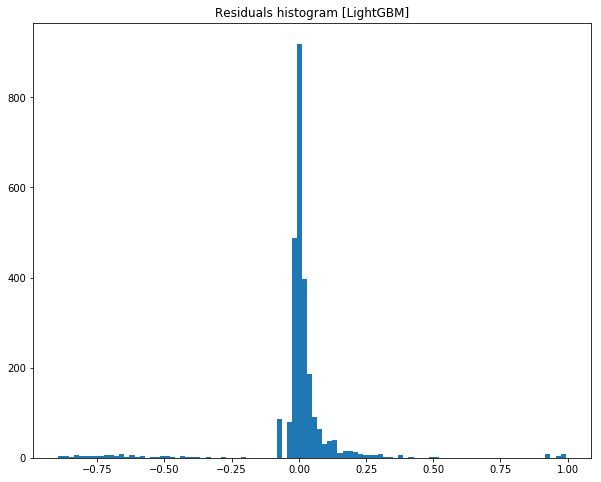

In [11]:
plt.figure(figsize=(10,8))

plt.hist(res, bins=100)
plt.title('Residuals histogram [LightGBM]')
plt.show()

#### Lasso

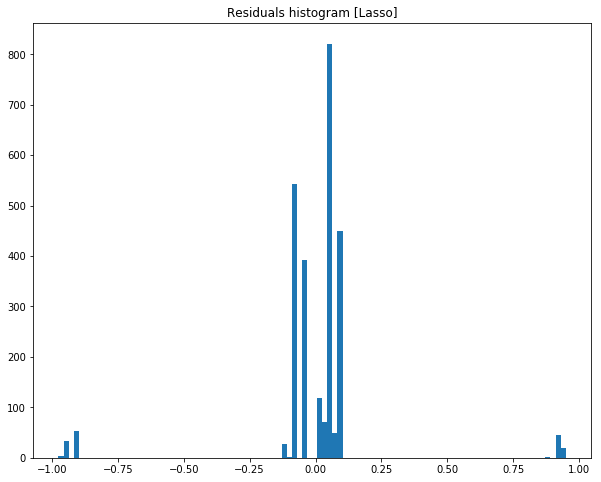

In [12]:
plt.figure(figsize=(10,8))

plt.hist(res_aux, bins=100)
plt.title('Residuals histogram [Lasso]')
plt.show()

### Residuals vs Fitted values plot
#### LightGBM

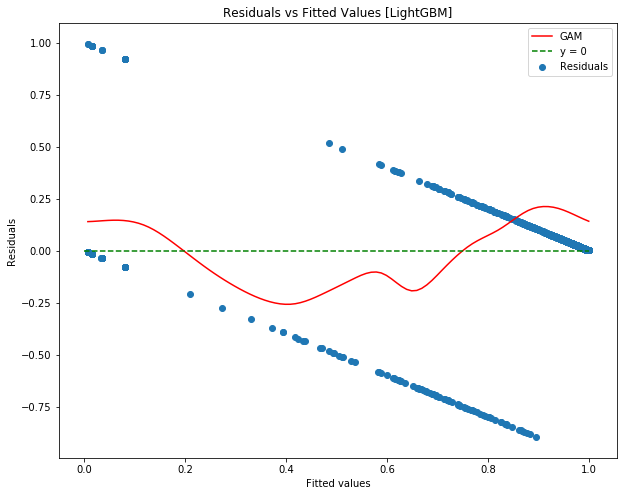

In [13]:
gam = LinearGAM().fit(y_hat, y_ - y_hat)

term = gam.terms[0]
XX = gam.generate_X_grid(term=0)
pdep = gam.partial_dependence(term=0, X=XX)

plt.figure(figsize=(10, 8))

plt.scatter(y_hat, y_ - y_hat, label='Residuals')
plt.plot(XX[:, term.feature], pdep, c='r', label='GAM')
plt.plot(np.linspace(0, 1, 10), np.repeat(0, 10), c='g', ls='--', label='y = 0')

plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title("Residuals vs Fitted Values [LightGBM]")
plt.legend()

plt.show()

#### Lasso

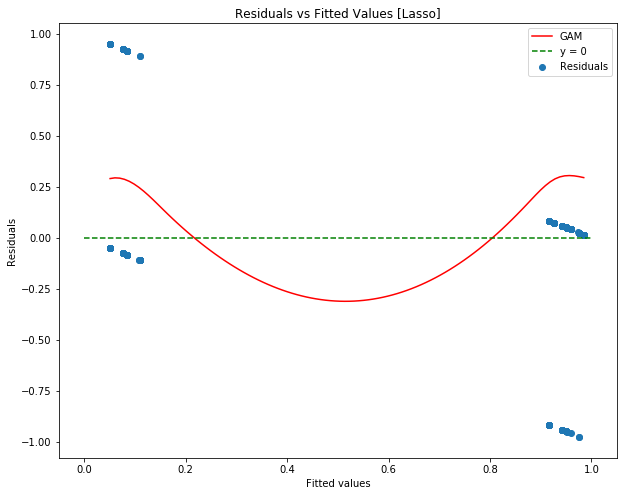

In [14]:
gam = LinearGAM().fit(y_hat_aux, y_ - y_hat_aux)

term = gam.terms[0]
XX = gam.generate_X_grid(term=0)
pdep = gam.partial_dependence(term=0, X=XX)

plt.figure(figsize=(10, 8))

plt.scatter(y_hat_aux, y_ - y_hat_aux, label='Residuals')
plt.plot(XX[:, term.feature], pdep, c='r', label='GAM')
plt.plot(np.linspace(0, 1, 10), np.repeat(0, 10), c='g', ls='--', label='y = 0')

plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title("Residuals vs Fitted Values [Lasso]")
plt.legend()

plt.show()

### Residuals vs Dependent Variable plot
#### LightGBM

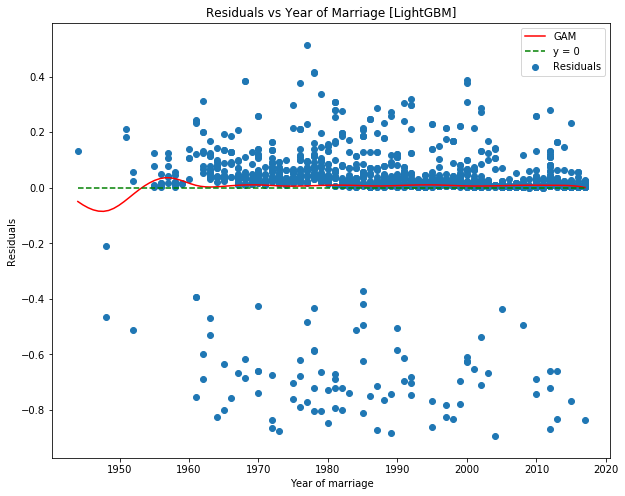

In [15]:
dep = X_train['w6_q21d_year']

res = res[pd.notna(dep)]
dep = dep[pd.notna(dep)]

gam = LinearGAM().fit(dep, res)

term = gam.terms[0]
XX = gam.generate_X_grid(term=0)
pdep = gam.partial_dependence(term=0, X=XX)

plt.figure(figsize=(10, 8))

plt.scatter(dep, res, label='Residuals')
plt.plot(XX[:, term.feature], pdep, c='r', label='GAM')
plt.plot(np.linspace(np.min(dep), np.max(dep), 10), np.repeat(0, 10), c='g', ls='--', label='y = 0')

plt.xlabel('Year of marriage')
plt.ylabel('Residuals')
plt.title("Residuals vs Year of Marriage [LightGBM]")
plt.legend()

plt.show()

#### Lasso

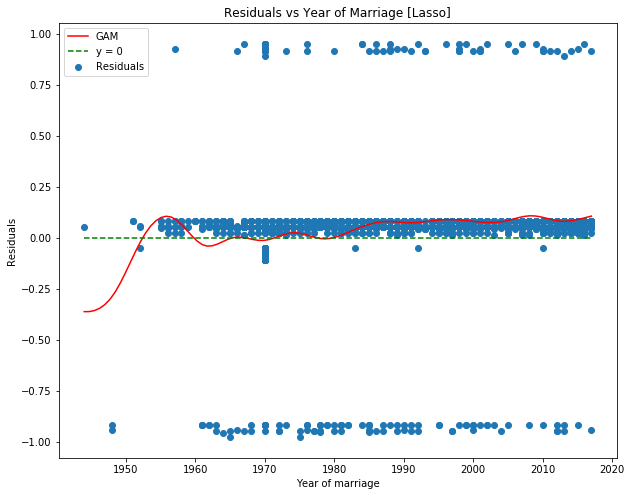

In [16]:
dep = X_train_aux['w6_q21d_year']

res = res[pd.notna(dep)]
dep = dep[pd.notna(dep)]

gam = LinearGAM().fit(dep, res_aux)

term = gam.terms[0]
XX = gam.generate_X_grid(term=0)
pdep = gam.partial_dependence(term=0, X=XX)

plt.figure(figsize=(10, 8))

plt.scatter(dep, res_aux, label='Residuals')
plt.plot(XX[:, term.feature], pdep, c='r', label='GAM')
plt.plot(np.linspace(np.min(dep), np.max(dep), 10), np.repeat(0, 10), c='g', ls='--', label='y = 0')

plt.xlabel('Year of marriage')
plt.ylabel('Residuals')
plt.title("Residuals vs Year of Marriage [Lasso]")
plt.legend()

plt.show()

### Cook's distance
#### LightGBM

In [17]:
n, p = X_train.shape

s2 = np.sum(res**2) / (n - p)
f05 = f.median(p, n - p)

In [18]:
print(f'n = {n}\np = {p}')
print(f'F(p, n-p) median = {f05:.5}')
print(f's^2 = {s2:.5}')

n = 2632
p = 4
F(p, n-p) median = 0.83939
s^2 = 0.020123


In [19]:
cooks = list()
# influence = list()

for i in range(n):
    X_i = X_train.copy().drop(X_train.index[i])
    y_i = y_train.copy().drop(y_train.index[i])

    clfi = LGBMClassifier(reg_alpha=0.5, random_state=0)
    clfi.fit(X_i, y_i)
    yi_hat = clfi.predict_proba(X_train)[:, 1]
    
    cooks.append(np.sum(np.power(y_hat - yi_hat, 2))/(p * s2))
    # influence.append(np.sqrt(np.mean(np.power(y_hat - yi_hat, 2))))

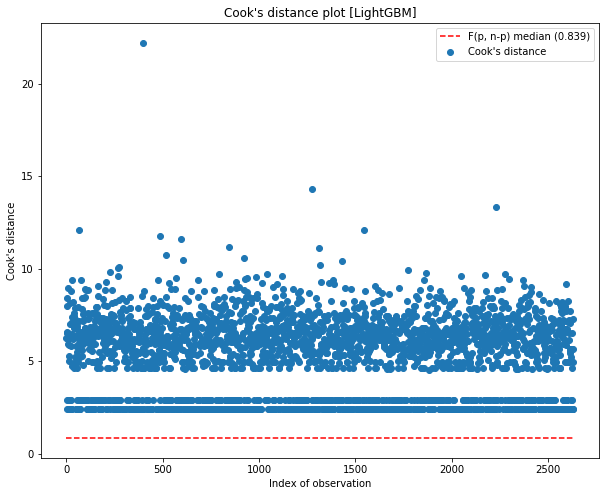

In [20]:
plt.figure(figsize=(10, 8))

plt.scatter(range(n), cooks, label='Cook\'s distance')
plt.plot(np.linspace(0, n, 10), np.repeat(f05, 10), c='r', ls='--', label=f'F(p, n-p) median ({f05:.3})')

plt.xlabel('Index of observation')
plt.ylabel('Cook\'s distance')
plt.title("Cook's distance plot [LightGBM]")
plt.legend()

plt.show()

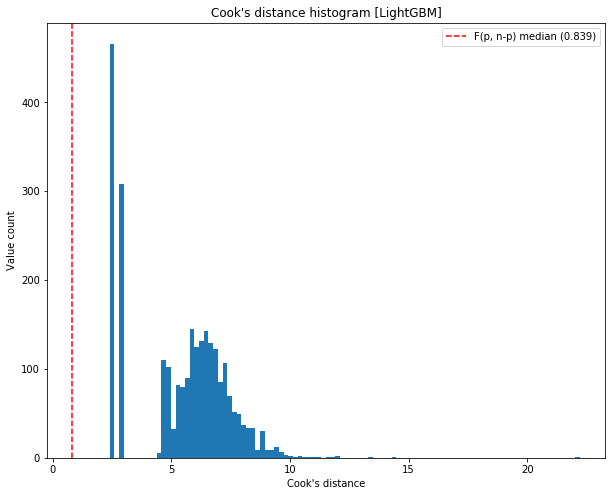

In [21]:
plt.figure(figsize=(10, 8))

plt.hist(cooks, bins=100)
plt.axvline(x=f05, color='r', ls='--',  label=f'F(p, n-p) median ({f05:.3})')

plt.xlabel('Cook\'s distance')
plt.ylabel('Value count')
plt.title("Cook's distance histogram [LightGBM]")
plt.legend()

plt.show()

#### Lasso

In [22]:
n, p = X_train_aux.shape

s2 = np.sum(res_aux**2)/ (n - p)
f05 = f.median(p, n - p)

In [23]:
print(f'n = {n}\np = {p}')
print(f'F(p, n-p) median = {f05:.5}')
print(f's^2 = {s2:.5}')

n = 2632
p = 4
F(p, n-p) median = 0.83939
s^2 = 0.056316


In [24]:
cooks = list()
# influence = list()

for i in range(n):
    X_i = X_train_aux.copy().drop(X_train_aux.index[i])
    y_i = y_train_aux.copy().drop(y_train_aux.index[i])

    clfi = new_lasso_clf()
    clfi.fit(X_i, y_i)
    yi_hat = clfi.predict(X_train_aux)
    
    cooks.append(np.sum(np.power(y_hat_aux - yi_hat, 2))/(p * s2))
    # influence.append(np.sqrt(np.mean(np.power(y_hat - yi_hat, 2))))

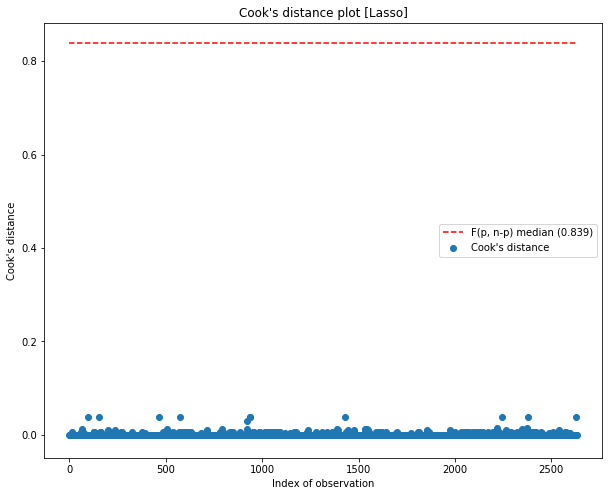

In [25]:
plt.figure(figsize=(10, 8))

plt.scatter(range(n), cooks, label='Cook\'s distance')
plt.plot(np.linspace(0, n, 10), np.repeat(f05, 10), c='r', ls='--', label=f'F(p, n-p) median ({f05:.3})')

plt.xlabel('Index of observation')
plt.ylabel('Cook\'s distance')
plt.title("Cook's distance plot [Lasso]")
plt.legend()

plt.show()

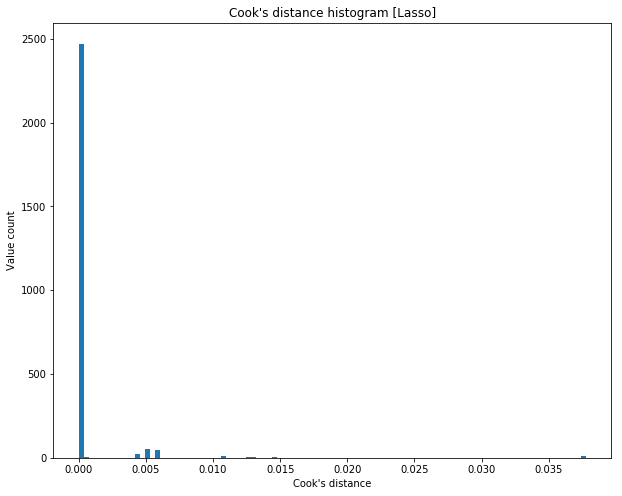

In [26]:
plt.figure(figsize=(10, 8))

plt.hist(cooks, bins=100)
# plt.axvline(x=f05, color='r', ls='--',  label=f'F(p, n-p) median ({f05:.3})')

plt.xlabel('Cook\'s distance')
plt.ylabel('Value count')
plt.title("Cook's distance histogram [Lasso]")
# plt.legend()

plt.show()

## Conclusion

### Residual vs Fitted values plot
The plot shows sharp divide in predictions of the model - there are almost no points for fitted values between 0.1 and 0.5.

### Residual vs Year of Marriage plot
GAM fitted to the plot of residuals almost perfectly lies on the y=0 line. Only for pairs married in the '60s model predicts lower probability of them being married than it should, and for the pairs married in the '50s - higher probability. This can be probably explained by smaller amount of data for the pairs from that time span.

### Cook's distance
All observations have Cook's distance higher than the median of F(p, n-p) distribution. The model is not very robust, as any change greatly alters its predictions.